<a href="https://colab.research.google.com/github/sufyn/image-content-filtration/blob/main/image_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip '/content/drive/MyDrive/data/newdata.zip'

Archive:  /content/drive/MyDrive/data/newdata.zip
   creating: Classification/Adult Content/
  inflating: Classification/Adult Content/test2 (10).jpg  
  inflating: Classification/Adult Content/test2 (100).JPG  
  inflating: Classification/Adult Content/test2 (105).JPG  
  inflating: Classification/Adult Content/test2 (106).JPG  
  inflating: Classification/Adult Content/test2 (111).jpg  
  inflating: Classification/Adult Content/test2 (117).jpg  
  inflating: Classification/Adult Content/test2 (118).jpg  
  inflating: Classification/Adult Content/test2 (122).jpg  
  inflating: Classification/Adult Content/test2 (130).jpg  
  inflating: Classification/Adult Content/test2 (134).jpg  
  inflating: Classification/Adult Content/test2 (14).jpg  
  inflating: Classification/Adult Content/test2 (140).jpg  
  inflating: Classification/Adult Content/test2 (150).jpg  
  inflating: Classification/Adult Content/test2 (151).jpg  
  inflating: Classification/Adult Content/test2 (155).jpg  
  inflati

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Define image size and paths
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
DATA_DIR = '/content/Classification'

# Create ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation datasets
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Print class indices to check the balance
print("Class indices:", train_generator.class_indices)
print("Number of samples in each class (train):", {k: v for k, v in zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes))})
print("Number of samples in each class (validation):", {k: v for k, v in zip(validation_generator.class_indices.keys(), np.bincount(validation_generator.classes))})


Found 239 images belonging to 3 classes.
Found 57 images belonging to 3 classes.
Class indices: {'Adult Content': 0, 'Safe': 1, 'Violent': 2}
Number of samples in each class (train): {'Adult Content': 80, 'Safe': 80, 'Violent': 79}
Number of samples in each class (validation): {'Adult Content': 19, 'Safe': 19, 'Violent': 19}


In [16]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights)


Class weights: {0: 0.9958333333333333, 1: 0.9958333333333333, 2: 1.0084388185654007}


Epoch 1/11
1/7 [===>..........................] - ETA: 2:09 - loss: 1.4170 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 [==============================] - 35s 2s/step - loss: 1.0566 - accuracy: 0.6135 - val_loss: 1.0067 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 2/11
7/7 [==============================] - 15s 2s/step - loss: 0.4838 - accuracy: 0.8406 - val_loss: 3.4027 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 3/11
7/7 [==============================] - 16s 2s/step - loss: 0.3280 - accuracy: 0.8792 - val_loss: 5.8738 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 4/11
7/7 [==============================] - 15s 2s/step - loss: 0.4363 - accuracy: 0.8551 - val_loss: 2.9826 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/11
7/7 [==============================] - 16s 2s/step - loss: 0.3175 - accuracy: 0.9034 - val_loss: 3.7836 - val_accuracy: 0.4375 - lr: 2.0000e-04
Epoch 6/11
2/2 [==============================] - 1s 248ms/step - loss: 0.8011 - accuracy: 0.7193
Validation Loss: 0.8010649681091309
Validation Accuracy: 0.719298243522644


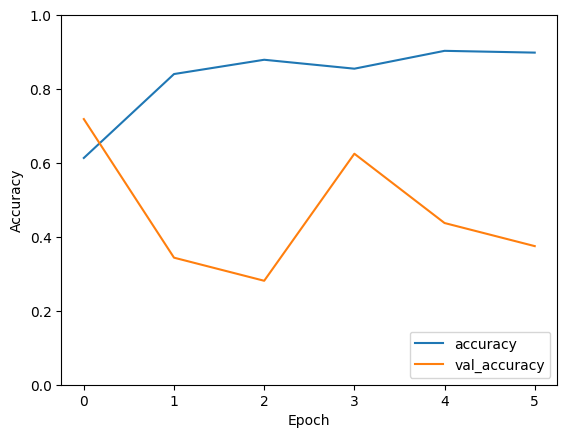

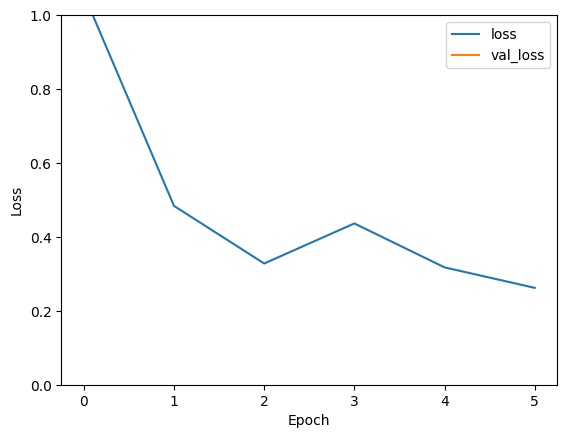

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Increasing dropout to reduce overfitting
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Train the model with class weights and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=11,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

import matplotlib.pyplot as plt

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

# Save the model
model.save('ml2.h5')


1/1 [==============================] - 1s 1s/step
[[9.9623835e-01 5.8698712e-04 3.1746132e-03]]


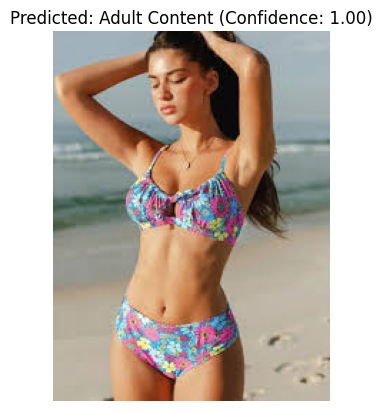

In [34]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('ml2.h5')

# Define the function to predict the class of a new image
def predict(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    print(prediction)
    return np.argmax(prediction, axis=1)[0], prediction

# Example usage with a new test image
test_image_path = '/content/adult.jpg'
label, prediction = predict(test_image_path)
categories = ['Adult Content','Safe','Violent']
predicted_category = categories[label]

# Display the test image and prediction
test_image = image.load_img(test_image_path)
plt.imshow(test_image)
plt.title(f'Predicted: {predicted_category} (Confidence: {prediction[0][label]:.2f})')
plt.axis('off')
plt.show()


In [37]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0
